## Read Data

In [ ]:
# 合併 JSON
import json

with open("NSC-4.json", "r") as file:
    c_data = json.load(file)

with open("output-3.json", "r") as file:
    o_data = json.load(file)

merged_data = c_data + o_data

with open("merged.json", "w") as file:
    json.dump(merged_data, file, indent=4)


In [ ]:
# 打散 JSON 檔中的資料

import json
import random


with open("merged.json", "r") as file:
    data = json.load(file)

random.shuffle(data)

with open("your_file.json", "w") as file:
    json.dump(data, file, indent=4)


In [ ]:
# txt 轉為 JSON 格式

import json

input_txt_path = 'OS-10output.txt'
output_json_path = 'OS.json'

with open(input_txt_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

data = [{"labels": 0, "text": line.strip().strip("\"").rstrip(",").rstrip("\"").strip()} for line in lines]

json_data = json.dumps(data, ensure_ascii=False, indent=4)

with open(output_json_path, 'w', encoding='utf-8') as file:
    file.write(json_data)

In [ ]:
# 一開始做的時候存內文的標籤打錯字，在這邊統一使用 "text"

import json

with open("1train.json", "r") as file:
    data = json.load(file)

for obj in data:
    obj["text"] = obj.pop("context")

with open("1train.json", "w") as file:
    json.dump(data, file, indent=4)

print("已將 'context' 標簽替換為 'text' 並寫入到新的 JSON 文件中。")

## Category Distribution 課程類別視覺化

In [ ]:
len(set(df_train['labels'].values))

2

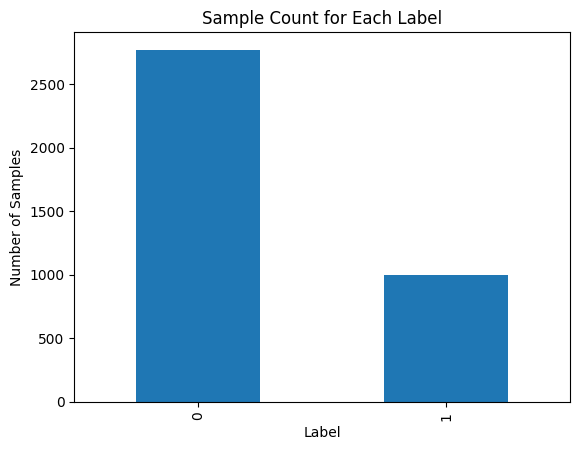

In [ ]:
import matplotlib.pyplot as plt

# 統計各個類別的樣本數量
label_counts = df_train['labels'].value_counts()

label_counts.plot(kind='bar')

# 設置標題和坐標軸標簽
plt.title('Sample Count for Each Label')
plt.xlabel('Label')
plt.ylabel('Number of Samples')

# 顯示圖形
plt.show()


## Logic Regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

import json

# train data
with open("/content/1train.json", "r") as file:
    data = file.read()
json_data = json.loads(data)
df_train = pd.DataFrame(json_data)
df_train['text'] = df_train.apply(lambda row: row['context'] if pd.isnull(row['text']) else (row['text'] if pd.isnull(row['context']) else row['context'] + " " + row['text']), axis=1)
df_train = df_train.drop(columns=['context'])

# test data
with open("/content/shuffled.json", "r") as file:
    data = file.read()
json_data = json.loads(data)
df_test = pd.DataFrame(json_data)
df_test['text'] = df_test.apply(lambda row: row['context'] if pd.isnull(row['text']) else (row['text'] if pd.isnull(row['context']) else row['context'] + " " + row['text']), axis=1)
df_test = df_test.drop(columns=['context'])

# 初始化 CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, max_features=100000)

# 提取訓練集和測試集的特征
x_train = vectorizer.fit_transform(df_train['text'])
x_test = vectorizer.transform(df_test['text'])

# 獲取標簽
y_train = df_train['labels']
y_true = df_test['labels']

# 未使用降維的模型
lg = LogisticRegression(C=4, dual=False)
lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)
accuracy_no_pca = accuracy_score(y_true, y_pred)
precision_no_pca = precision_score(y_true, y_pred, average='weighted')
recall_no_pca = recall_score(y_true, y_pred, average='weighted')
f1_no_pca = f1_score(y_true, y_pred, average='weighted')

# 使用 TruncatedSVD 進行降維
svd = TruncatedSVD(n_components=10)  # 選擇合適的組件數量
x_train_reduced = svd.fit_transform(x_train)
x_test_reduced = svd.transform(x_test)

# 降維後的模型
lg_reduced = LogisticRegression(C=4, dual=False)
lg_reduced.fit(x_train_reduced, y_train)
y_pred_reduced = lg_reduced.predict(x_test_reduced)
accuracy_pca = accuracy_score(y_true, y_pred_reduced)
precision_pca = precision_score(y_true, y_pred_reduced, average='weighted')
recall_pca = recall_score(y_true, y_pred_reduced, average='weighted')
f1_pca = f1_score(y_true, y_pred_reduced, average='weighted')

# 輸出結果
print(f"Without Dimensionality Reduction: Accuracy: {accuracy_no_pca:.4f}, Precision: {precision_no_pca:.4f}, Recall: {recall_no_pca:.4f}, F1-Score: {f1_no_pca:.4f}")
print(f"With Dimensionality Reduction: Accuracy: {accuracy_pca:.4f}, Precision: {precision_pca:.4f}, Recall: {recall_pca:.4f}, F1-Score: {f1_pca:.4f}")


Without Dimensionality Reduction: Accuracy: 0.5385, Precision: 0.7618, Recall: 0.5385, F1-Score: 0.4198
With Dimensionality Reduction: Accuracy: 0.5231, Precision: 0.7578, Recall: 0.5231, F1-Score: 0.3897


## TF-IDF

### 尚未降維

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Dataset
with open("/content/merged.json", "r") as file:
    data = file.read()

json_data = json.loads(data)
print(json_data)

df = pd.DataFrame(json_data)


# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.25, random_state=42)

# 計算TF-IDF特徵
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 訓練邏輯回歸分類器
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# 預測測試集
y_pred = classifier.predict(X_test_tfidf)

# 評估模型
# print(classification_report(y_test, y_pred))

from sklearn.metrics import classification_report

# 預測測試集
y_pred = classifier.predict(X_test_tfidf)

# 評估模型
report = classification_report(y_test, y_pred, output_dict=True)

accuracy = accuracy_score(y_test, y_pred)

# 將結果四舍五入到小數點後四位
precision_0 = round(report['0']['precision'], 4)
recall_0 = round(report['0']['recall'], 4)
f1_score_0 = round(report['0']['f1-score'], 4)

precision_1 = round(report['1']['precision'], 4)
recall_1 = round(report['1']['recall'], 4)
f1_score_1 = round(report['1']['f1-score'], 4)

print("Accuracy:", round(accuracy, 4))
print()
print("Class 0:")
print("Precision:", precision_0)
print("Recall:", recall_0)
print("F1 Score:", f1_score_0)
print()

print("Class 1:")
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_score_1)

### 降低資料維度

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
import pandas as pd
import json

# Dataset
with open("/content/merged.json", "r") as file:
    data = file.read()

json_data = json.loads(data)
df = pd.DataFrame(json_data)

# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.25, random_state=42)

# 創建一個管道，其中包含 TF-IDF 向量化、TruncatedSVD 降維和邏輯回歸分類器
pipeline = make_pipeline(
    TfidfVectorizer(),
    TruncatedSVD(n_components=10),  # 調整 n_components 為合適的值，我建置的資料集特徵較少，不超過 30
    LogisticRegression()
)

# 訓練模型
pipeline.fit(X_train, y_train)

# 預測測試集
y_pred = pipeline.predict(X_test)

# 評估模型
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# 將結果四舍五入到小數點後四位
precision_0 = round(report['0']['precision'], 4)
recall_0 = round(report['0']['recall'], 4)
f1_score_0 = round(report['0']['f1-score'], 4)

precision_1 = round(report['1']['precision'], 4)
recall_1 = round(report['1']['recall'], 4)
f1_score_1 = round(report['1']['f1-score'], 4)

print("Accuracy:", round(accuracy, 4))
print("\nClass 0:")
print("Precision:", precision_0)
print("Recall:", recall_0)
print("F1 Score:", f1_score_0)
print("\nClass 1:")
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_score_1)


## Dataframe 階段文本處理

In [ ]:
# 在 DATAFRAME 階段，修正 JSON 檔的標籤命名錯誤問題
import pandas as pd
import numpy as np
import json

# 讀取 JSON 文件
with open("/content/1train.json", "r") as file:
    data = file.read()

json_data = json.loads(data)

print(json_data)

# 假設 df 是你已經加載的包含 'labels', 'context', 和 'text' 列的 DataFrame
# 以下代碼將創建一個新的 'text' 列，它合並了 'context' 和 'text' 列的數據

df = pd.DataFrame(json_data)
# 使用 apply 函數來遍歷每行，合並 'context' 和 'text' 列
df['text'] = df.apply(lambda row: row['context'] if pd.isnull(row['text']) else (row['text'] if pd.isnull(row['context']) else row['context'] + " " + row['text']), axis=1)

# 如果你只想保留合並後的 'text' 列和 'labels' 列，可以選擇刪除原始的 'context' 列
df = df.drop(columns=['context'])

# 此時 df['text'] 已經是合並後的文本，你可以繼紺使用 df 進行之後的操作
print(df)

with open("/content/1train.json", "w", encoding="utf-8") as file:
    file.write(json_output)



In [ ]:
df.sample(100)

In [ ]:
#number of rows (datapoints)
len(df)

In [ ]:
df.dtypes